In [1]:

from utils import *
from wrapper import ReconLLR, ReconLplusS, ReconHAAR, ReconHAAR_CORE
import matplotlib
import matplotlib.pyplot
import scipy.io as sio
torch.set_num_threads(os.cpu_count())
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_path = './kspc_volN1.mat'
data = sio.loadmat(data_path)
kspc = data['kspc']
csm = data['smaps']
kspc = np.transpose(kspc, (4,3,5,0,1,2))
csm =np.transpose(csm, (3, 0, 1,2))
sos = np.sqrt(np.sum(np.abs(csm) ** 2, axis=0, keepdims=True)) + 1e-11
csm /= sos
Nv, Nt, Nc, FE, PE, SPE = kspc.shape

In [2]:
img_llr = ReconLLR(kspc, csm, reg=1e-2, blk=8, itmethod='POGM', it=200, Lc=1., device='cuda:7', verbose=0, stopth=1e-4).cpu().numpy()

LOAD KSPC SHAPE torch.Size([4, 25, 5, 92, 96, 20]) LOAD CSM SHAPE torch.Size([5, 92, 96, 20]) US RATE: tensor(12.6382, device='cuda:7')


 13%|█▎        | 26/200 [00:34<03:51,  1.33s/it, loss=18814.77734, loss_DC=14072.03711, loss_LR=4742.74023]


In [3]:
img_ls = ReconLplusS(kspc, csm, regL=1e-2, regS=1e-2, blk=8, HADAMARD=1, itmethod='POGM', it=200, Lc=2., device='cuda', verbose=0, stopth=1e-3).cpu().numpy()

LOAD KSPC SHAPE torch.Size([4, 25, 5, 92, 96, 20]) LOAD CSM SHAPE torch.Size([5, 92, 96, 20]) US RATE: tensor(12.6382, device='cuda:0')


  8%|▊         | 16/200 [00:21<04:10,  1.36s/it, loss=20409.37517, loss_DC=9847.58008, loss_LR=2087.61134, loss_S=8474.18375] 


In [4]:
regt = 0.01
regs = 0.001
img_haar = ReconHAAR(kspc, csm, 
                reg_list = np.array([regt, regt, regt, regt, regt, regt, regt, regt, regs, regs, regs, regs, regs, regs, regs, regs]),
                itmethod='POGM', it=200, Lc=1., device='cuda', verbose=0, stopth=1e-4).cpu().numpy()

LOAD KSPC SHAPE torch.Size([4, 25, 5, 92, 96, 20]) LOAD CSM SHAPE torch.Size([5, 92, 96, 20]) US RATE: tensor(12.6382, device='cuda:0')


 44%|████▍     | 89/200 [02:07<02:39,  1.44s/it, loss=36136.55887, loss_DC=10614.40723, loss_H=25522.15164]


In [5]:
img_core, v = ReconHAAR_CORE(kspc, csm,  
                            gStp=0.1, mu1=0.5, mu2=0.5, lam1=0.001 * np.array([10, 10, 10, 10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1e-2]), lam2=0.075, 
                            oIter=200, iIter=5,device='cuda', verbose=0, stopth=1e-3)
img_core = img_core.cpu().numpy()
v = v.cpu().numpy()

LOAD KSPC SHAPE torch.Size([4, 25, 5, 92, 96, 20]) LOAD CSM SHAPE torch.Size([5, 92, 96, 20]) US RATE: tensor(12.6382, device='cuda:0')


 53%|█████▎    | 106/200 [11:51<10:30,  6.71s/it, obj=8033.17969, objA=1517.58911, objW=6358.22754, objV=157.36307] 


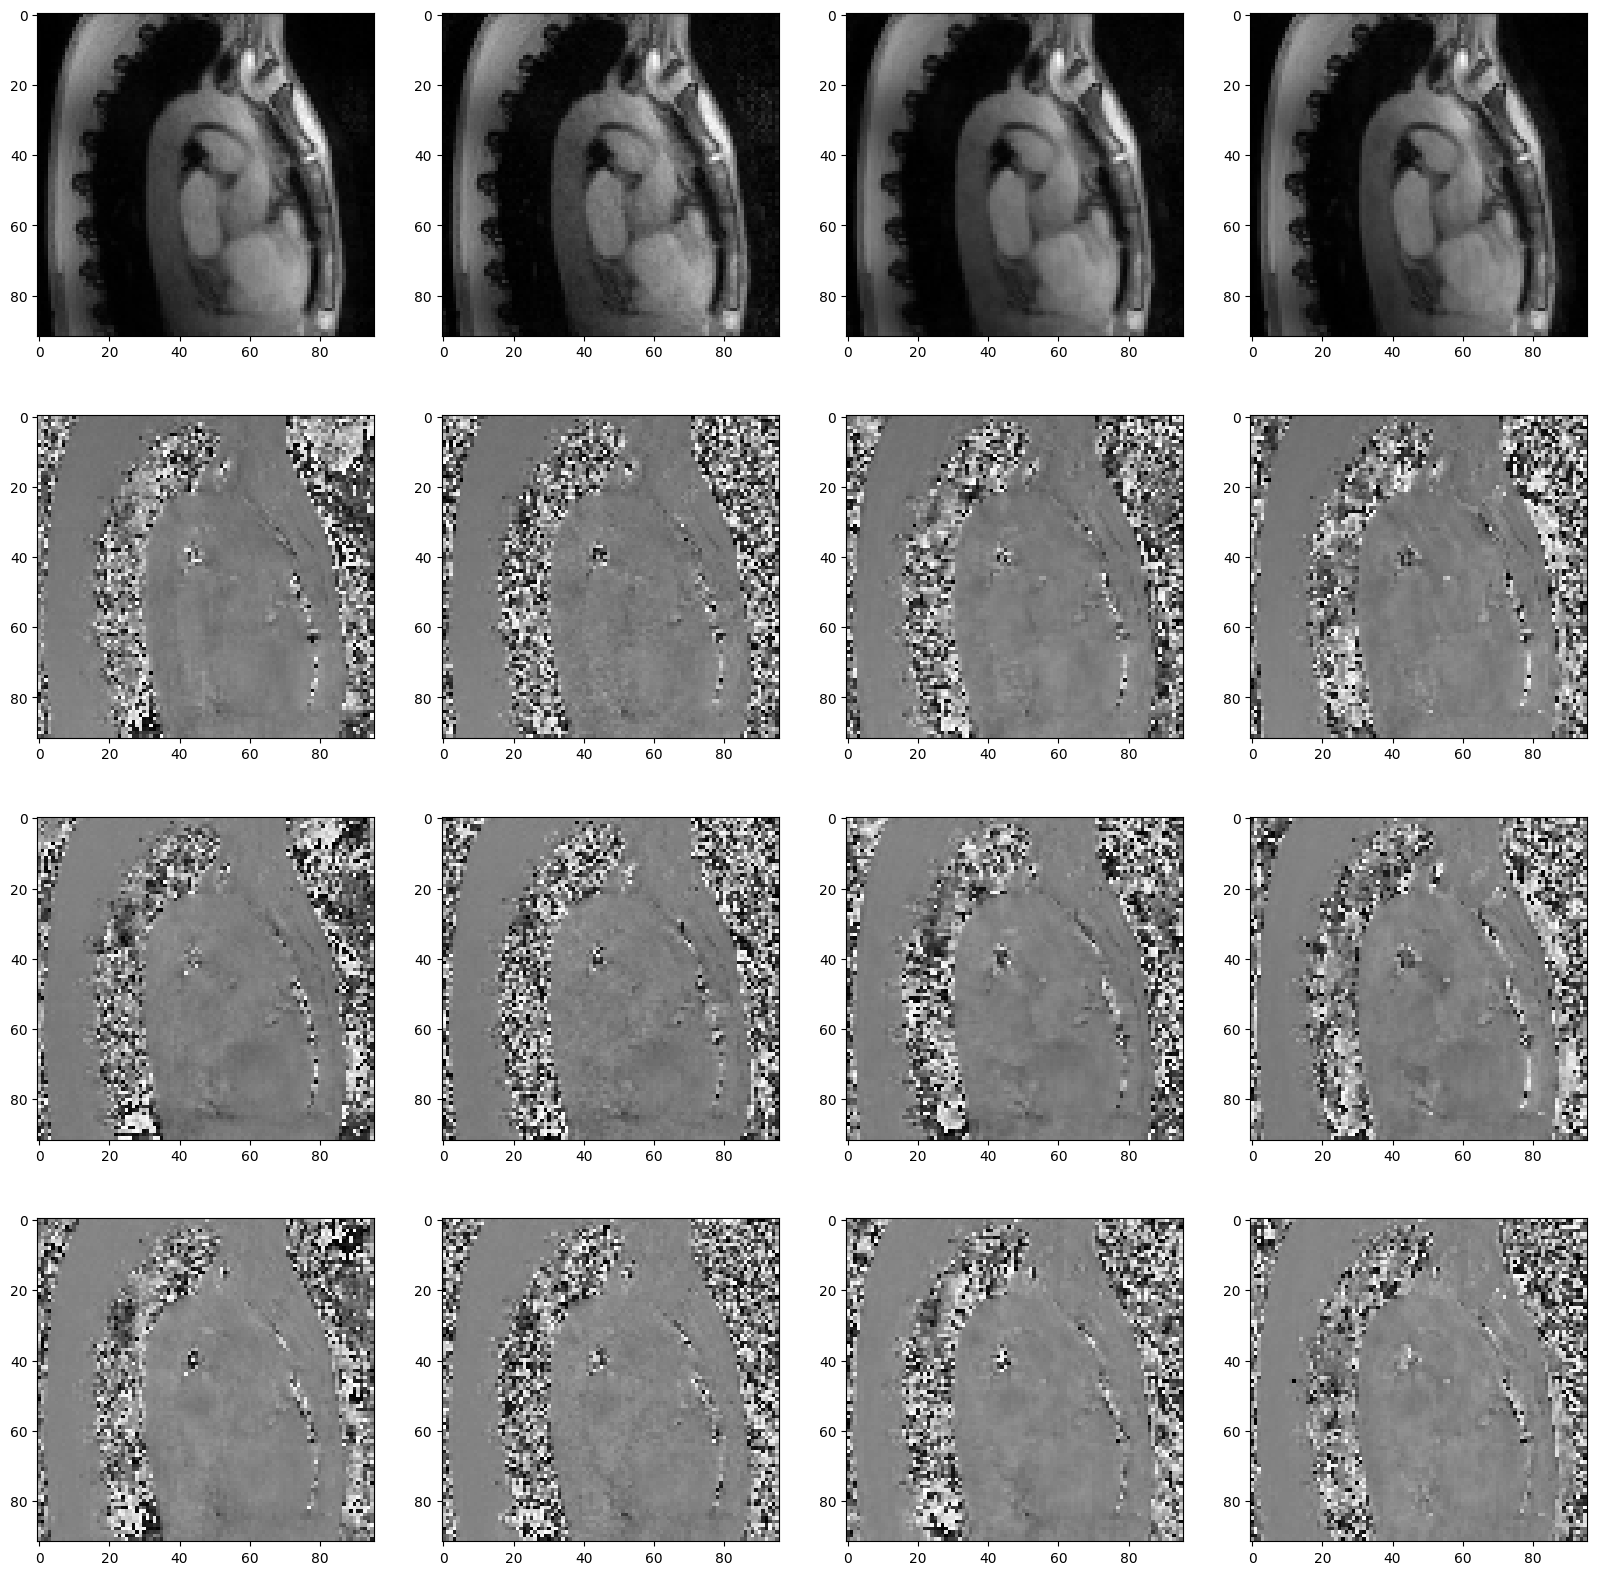

KeyboardInterrupt: 

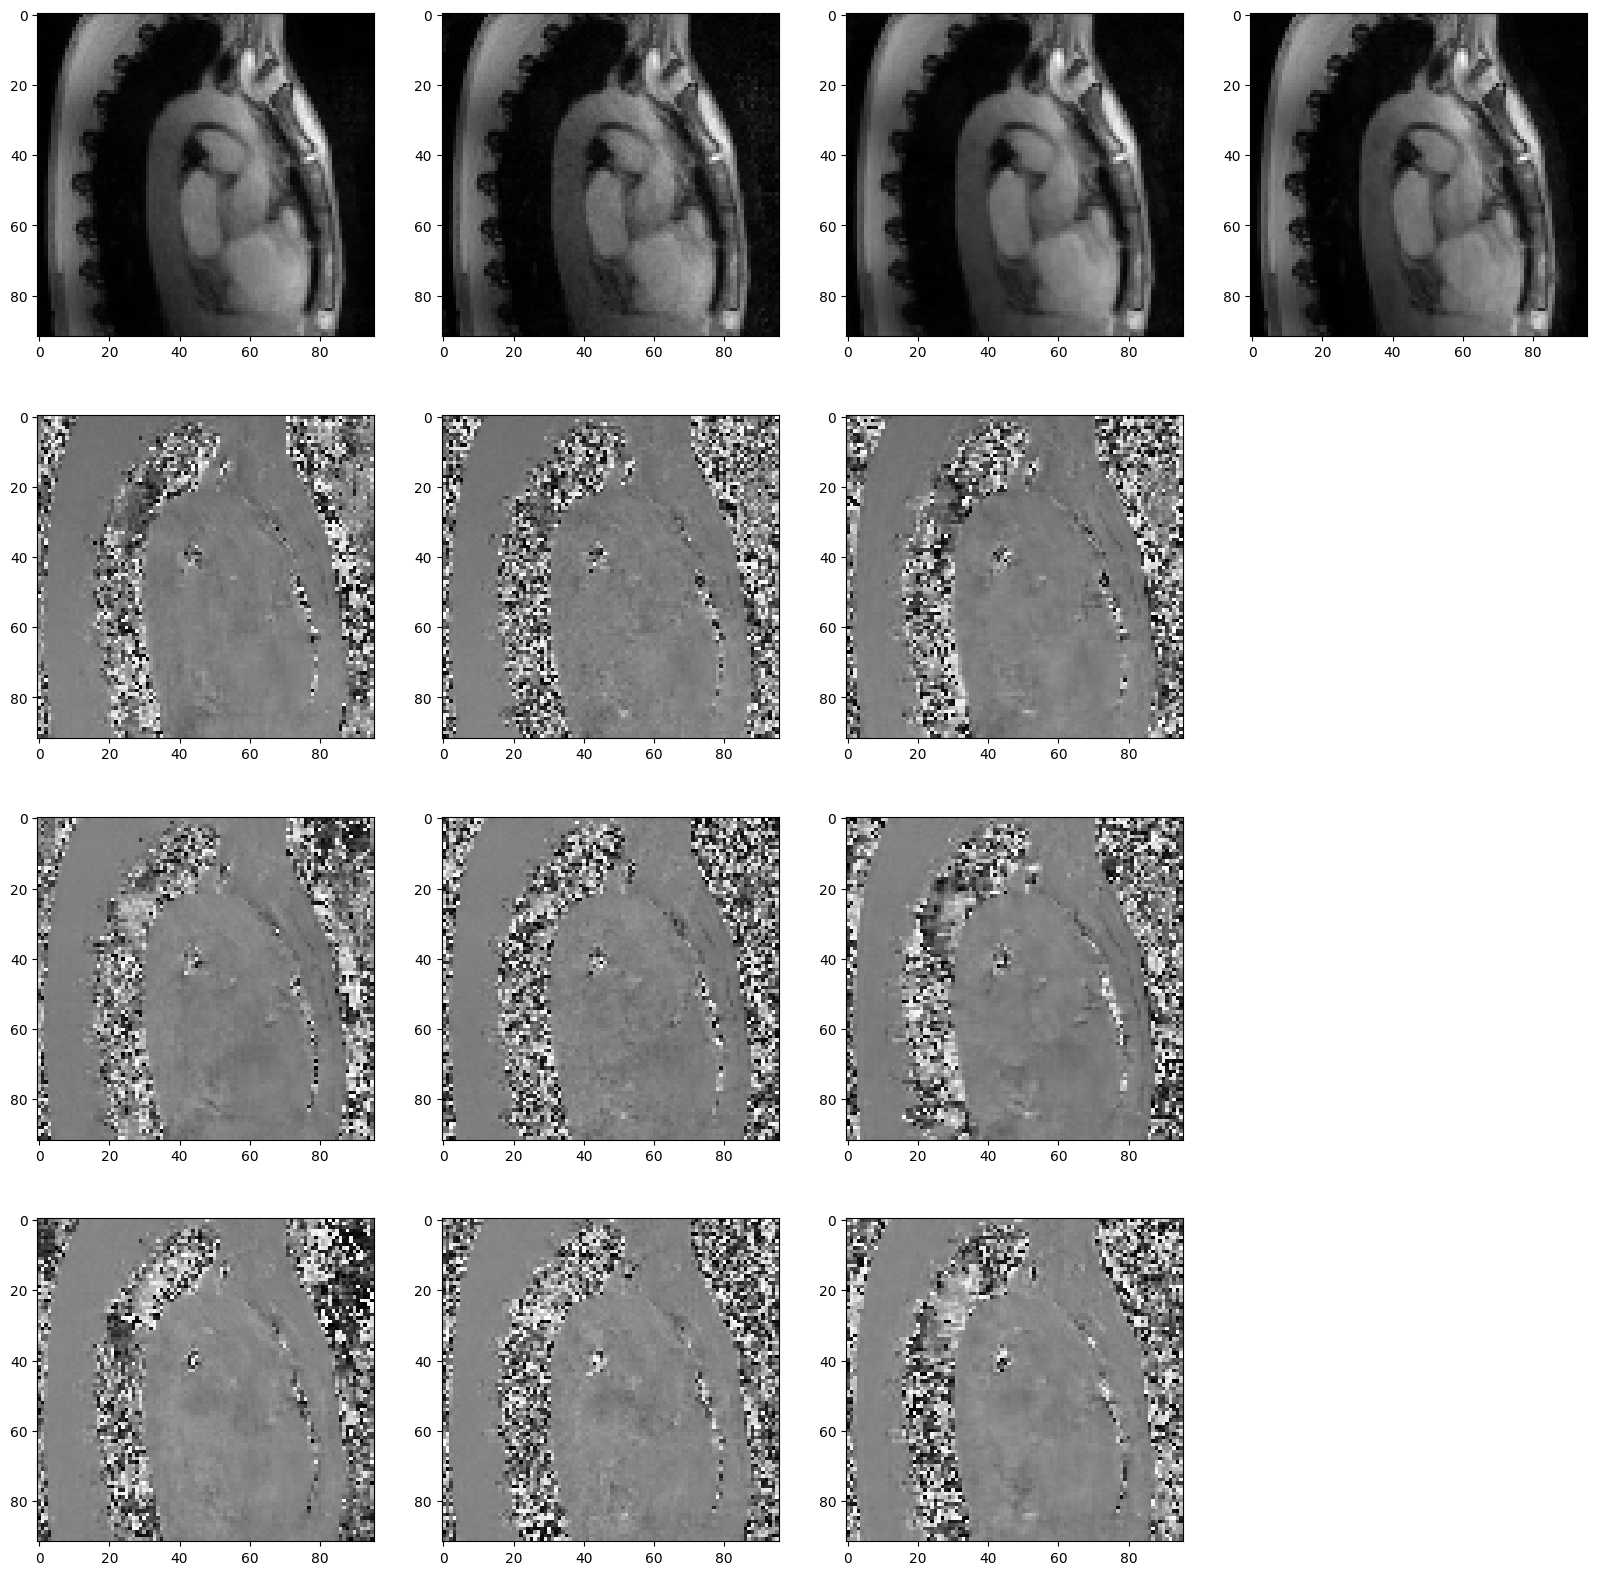

In [8]:
# The hyperparameters have not been fine-tuned; this only displays the reconstruction results of different methods without any comparative intention.
from IPython import display
row = 4
col = 4
venc = 150
show_spe = 10
for show_t in range(img_llr.shape[1]):
    plt.figure(figsize=(col*5, row*5))
    for i, img in enumerate([img_llr, img_ls, img_haar, img_core]):
        plt.subplot(row, col, i + 1)
        plt.imshow(np.abs(img[:, show_t, :, :, show_spe]).mean(0),cmap='gray')
        flow = np.angle(img[1:] * np.conj(img[0:1])) / np.pi * venc
        for j in range(3):
            plt.subplot(row, col, col * (j + 1) + i + 1)
            plt.imshow(flow[j, show_t, :, :, show_spe],cmap='gray')
            plt.clim(-venc, venc)
    display.clear_output(wait=True)
    plt.pause(0.01)
plt.show()